In [1]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 38.4 MB/s eta 0:00:00


In [2]:
!pip install kaggle

In [3]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

**import**

In [7]:
import shutil
import os
import zipfile
import pathlib
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [8]:
!kaggle datasets download -d vijaykumar1799/face-mask-detection

 98% 217M/222M [00:08<00:00, 30.9MB/s]
100% 222M/222M [00:08<00:00, 27.5MB/s]


**Copy zip file to colab**

**Extract dataset**

In [9]:
local_zip = '/content/face-mask-detection.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

**Directory**

In [10]:
data_dir = '/content/Dataset'
data_dir

'/content/Dataset'

In [11]:
os.listdir(data_dir)

['mask_weared_incorrect', 'with_mask', 'without_mask']

**Calculate and display image distribution before deletion.**

In [12]:
image_count = len(list(pathlib.Path(data_dir).glob('*/*.png')))
print(f'Total images in the dataset: {image_count}')

print('\nImage Distribution:')
for i, label in enumerate(os.listdir(data_dir)):
    label_dir = os.path.join(data_dir, label)
    len_label_dir = len(os.listdir(label_dir))
    print(f'{i+1}. {label} : {len_label_dir}')

Total images in the dataset: 8982

Image Distribution:
1. mask_weared_incorrect : 2994
2. with_mask : 2994
3. without_mask : 2994


**Augmentation and load data**

In [13]:
BATCH_SIZE = 64
IMG_SIZE = (150, 150)

train_datagen = ImageDataGenerator(rescale=1./255.0,
                                   rotation_range=15,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2)

**Flow From Directory**

In [14]:
train_generator = train_datagen.flow_from_directory(data_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='categorical',
                                                    subset='training')

validation_generator = train_datagen.flow_from_directory(data_dir,
                                                         target_size=IMG_SIZE,
                                                         batch_size=BATCH_SIZE,
                                                         class_mode='categorical',
                                                         subset='validation')

Found 7188 images belonging to 3 classes.
Found 1794 images belonging to 3 classes.


**Model**

In [15]:
model = tf.keras.models.Sequential([
    VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


58889256/58889256 [==============================] - 2s 0us/step


In [16]:
# Display the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 64)          294976    
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 1, 64)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1, 1, 64)          0         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 512)               33280     
                                                        

**Compile the model**

In [17]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

**Callback to stop training when both training and validation accuracy reach 90%**

In [18]:
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self, min_epochs=10):
    self.min_epochs = min_epochs
    self.epochs_passed = 0

  def on_epoch_end(self, epoch, logs={}):
    self.epochs_passed += 1

    if self.epochs_passed >= self.min_epochs and logs.get('accuracy') > 0.9:
      print(f"Training stopped as both training and validation accuracy reached 90% after {self.epochs_passed} epochs")
      self.model.stop_training = True

callbacks = myCallback()

early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

**Train the model**

In [19]:
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=5,
    verbose=2,
    callbacks=[callbacks, early_stopping]
)

Epoch 1/100
113/113 - 111s - loss: 0.3121 - accuracy: 0.8723 - val_loss: 0.1847 - val_accuracy: 0.9531 - 111s/epoch - 986ms/step
Epoch 2/100
113/113 - 75s - loss: 0.0931 - accuracy: 0.9698 - val_loss: 0.0907 - val_accuracy: 0.9750 - 75s/epoch - 663ms/step
Epoch 3/100
113/113 - 77s - loss: 0.0533 - accuracy: 0.9836 - val_loss: 0.1135 - val_accuracy: 0.9719 - 77s/epoch - 685ms/step
Epoch 4/100
113/113 - 77s - loss: 0.0398 - accuracy: 0.9878 - val_loss: 0.0287 - val_accuracy: 0.9969 - 77s/epoch - 677ms/step
Epoch 5/100
113/113 - 76s - loss: 0.0345 - accuracy: 0.9897 - val_loss: 0.0430 - val_accuracy: 0.9875 - 76s/epoch - 674ms/step
Epoch 6/100
113/113 - 75s - loss: 0.0219 - accuracy: 0.9939 - val_loss: 0.0708 - val_accuracy: 0.9781 - 75s/epoch - 666ms/step
Epoch 7/100
113/113 - 93s - loss: 0.0297 - accuracy: 0.9905 - val_loss: 0.0666 - val_accuracy: 0.9812 - 93s/epoch - 823ms/step
Epoch 8/100
113/113 - 76s - loss: 0.0315 - accuracy: 0.9904 - val_loss: 0.0406 - val_accuracy: 0.9906 - 76s/e

In [20]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')

<ipython-input-20-036bcfb1f050>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


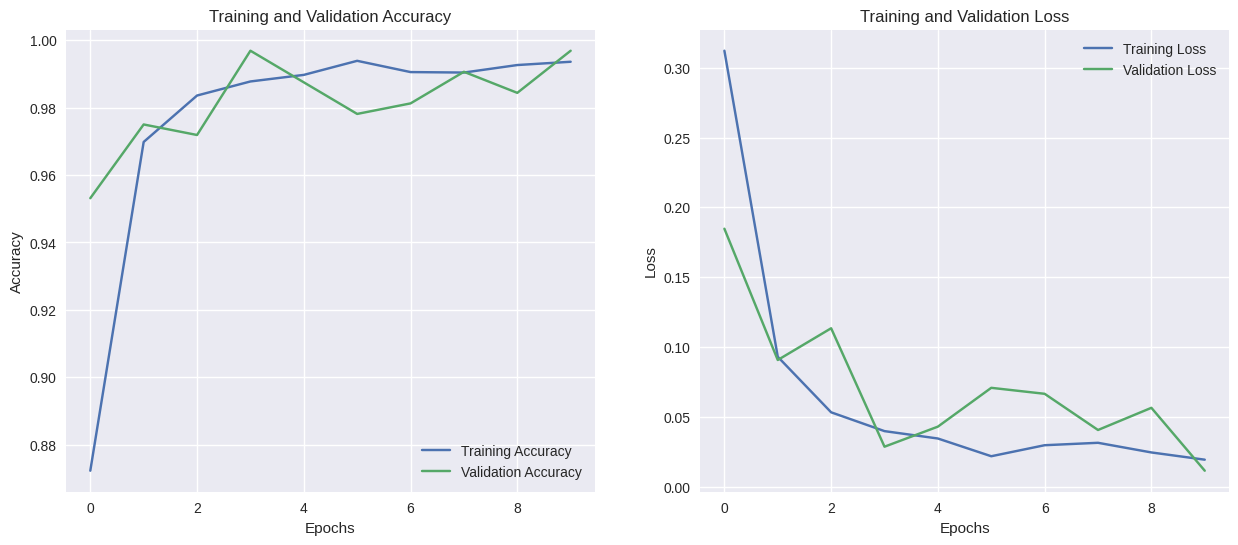

In [21]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

**Testing Model**

In [22]:
print(train_generator.class_indices)

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}


Saving 1000.png to 1000.png
1/1 [==============================] - 1s 1s/step
1000.png
with_mask


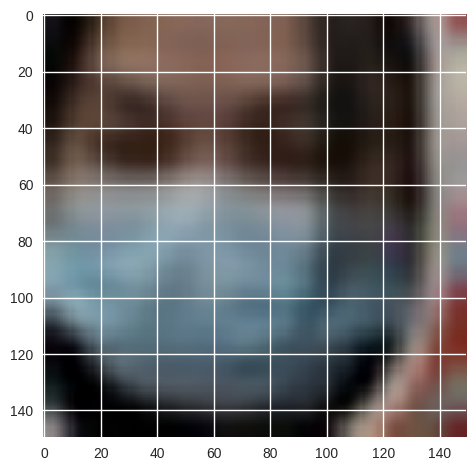

In [23]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn
  img = image.load_img(path, target_size=(150, 150))

  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=32)
  print(fn)
  if classes[0][0]==1:
    print('mask_weared_incorrect')
  elif classes[0][1]==1:
    print('with_mask')
  elif classes[0][2]==1:
    print('without_mask')
  else:
    print('UNKNOWN')


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

In [25]:
true_labels = []
predicted_labels = []

for i in range(len(validation_generator)):
    x_batch, y_batch = validation_generator[i]
    true_labels.extend(np.argmax(y_batch, axis=1))
    predicted_labels.extend(np.argmax(model.predict(x_batch), axis=1))

1/1 [==============================] - 1s 962ms/step


In [26]:
print("Classification Report:")
print(classification_report(true_labels, predicted_labels))

print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       598
           1       0.99      0.98      0.99       598
           2       0.99      0.99      0.99       598

    accuracy                           0.99      1794
   macro avg       0.99      0.99      0.99      1794
weighted avg       0.99      0.99      0.99      1794

Confusion Matrix:
[[596   1   1]
 [  5 587   6]
 [  1   5 592]]


**Save model to SavedModel format**

In [34]:
model.save('/content/saved_model')

**Convert SavedModel to JSON**

In [35]:
!tensorflowjs_converter --input_format=tf_saved_model \
                        --output_format=tfjs_graph_model \
                        saved_model \
                        tfjs_model


2024-01-19 08:09:51.107172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 08:09:51.107245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 08:09:51.109209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 08:09:52.761375: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-01-19 08:09:54.868760: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [36]:
shutil.make_archive('/content/tfjs_model_archive', 'zip', '/content/tfjs_model')

'/content/tfjs_model_archive.zip'

In [37]:
files.download('/content/tfjs_model_archive.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>